In [2]:
using LinearAlgebra
using ExponentialUtilities
using SparseArrays
using CairoMakie
using LaTeXStrings

We sutdy a simple 2D robot with a point mass $m$ and rather simple dynamics. The state consists of two positions and two velocities, i.e., 
$$x = \begin{pmatrix}p_1 \\ v_1 \\ p_2 \\ v_2 \end{pmatrix}.$$ 
The robot has accelerators in both directions that can change the velocity. Moreover, it is subject to friction according to a friction constant $d$. In total, we obtain the linear system
$$ \dot{x}(t) = A_c x(t) + B_c u(t) = \begin{pmatrix} 0 & 1 & 0 & 0 \\ 0 & -d/m & 0 & 0 \\0 & 0 & 0 & 1 \\0 & 0 & 0 & -d/m \end{pmatrix} x(t) + \begin{pmatrix} 0 & 0 \\ 1 & 0 \\ 0 & 0 \\ 0 & 1 \end{pmatrix} u(t),$$
where the subscript $_c$ stands for _continuous_.

In [3]:
# System matrices in continuous time

d = 10;    # friction parameter
m = 1000;  # vehicle mass

# Ac and Bc
Ac = [0  1   0  0;
      0 -d/m 0  0;
      0  0   0  1;
      0  0   0 -d/m];

Bc = [0 0;
      1 0;
      0 0;
      0 1];

As we have seen before, we can transform this system into a discrete-time system when introducing a time step $\Delta t$ and a corresponding time grid $t = \{t_0, t_1, \ldots, t_N\}$, as well as a zero-order hold for the input $u(t)$ over the time intervals $[t_0, t_1)$, $[t_1,t_2)$, etc:
$$ A = e^{A_c \Delta t} \qquad \text{and} \qquad B = \left(\int_0^{\Delta t} e^{A(\Delta t-\tau)} d\tau \right) B_c. $$

This yields the dynamics
$$ x[k+1] = A x[k] + B u[k].$$

In [4]:
dt = 0.1;   # time step for discretization
n = 4;      # state dimension
m = 2;      # input dimension

# Discrete-time system matrices
A = exponential!(Ac*dt);

# Numerical integration using the trapezoidal rule to obtain the B matrix
ddt = dt / 100;
B = 0.5 .* exponential!(Ac*dt);
for i in 1 : 99
    B += exponential!(Ac*(dt - i * ddt));
end
B += 0.5 .* I;
B *= ddt;
B *= Bc;

In [5]:
x0 = [2; 1; 0; 1]; # initial condition
N = 50;            # number of time steps
T = N * dt;        # final time

# time array
t = LinRange(0, T, N + 1)

# exemplary input
u = [-LinRange(0, 1, N)'; LinRange(-1, 1, N)']

# simulate trajectory in standard form
x = zeros(n, N + 1)
x[:, 1] = x0
for k in 1 : N
    x[:, k + 1] = A * x[:, k] + B * u[:, k]
end

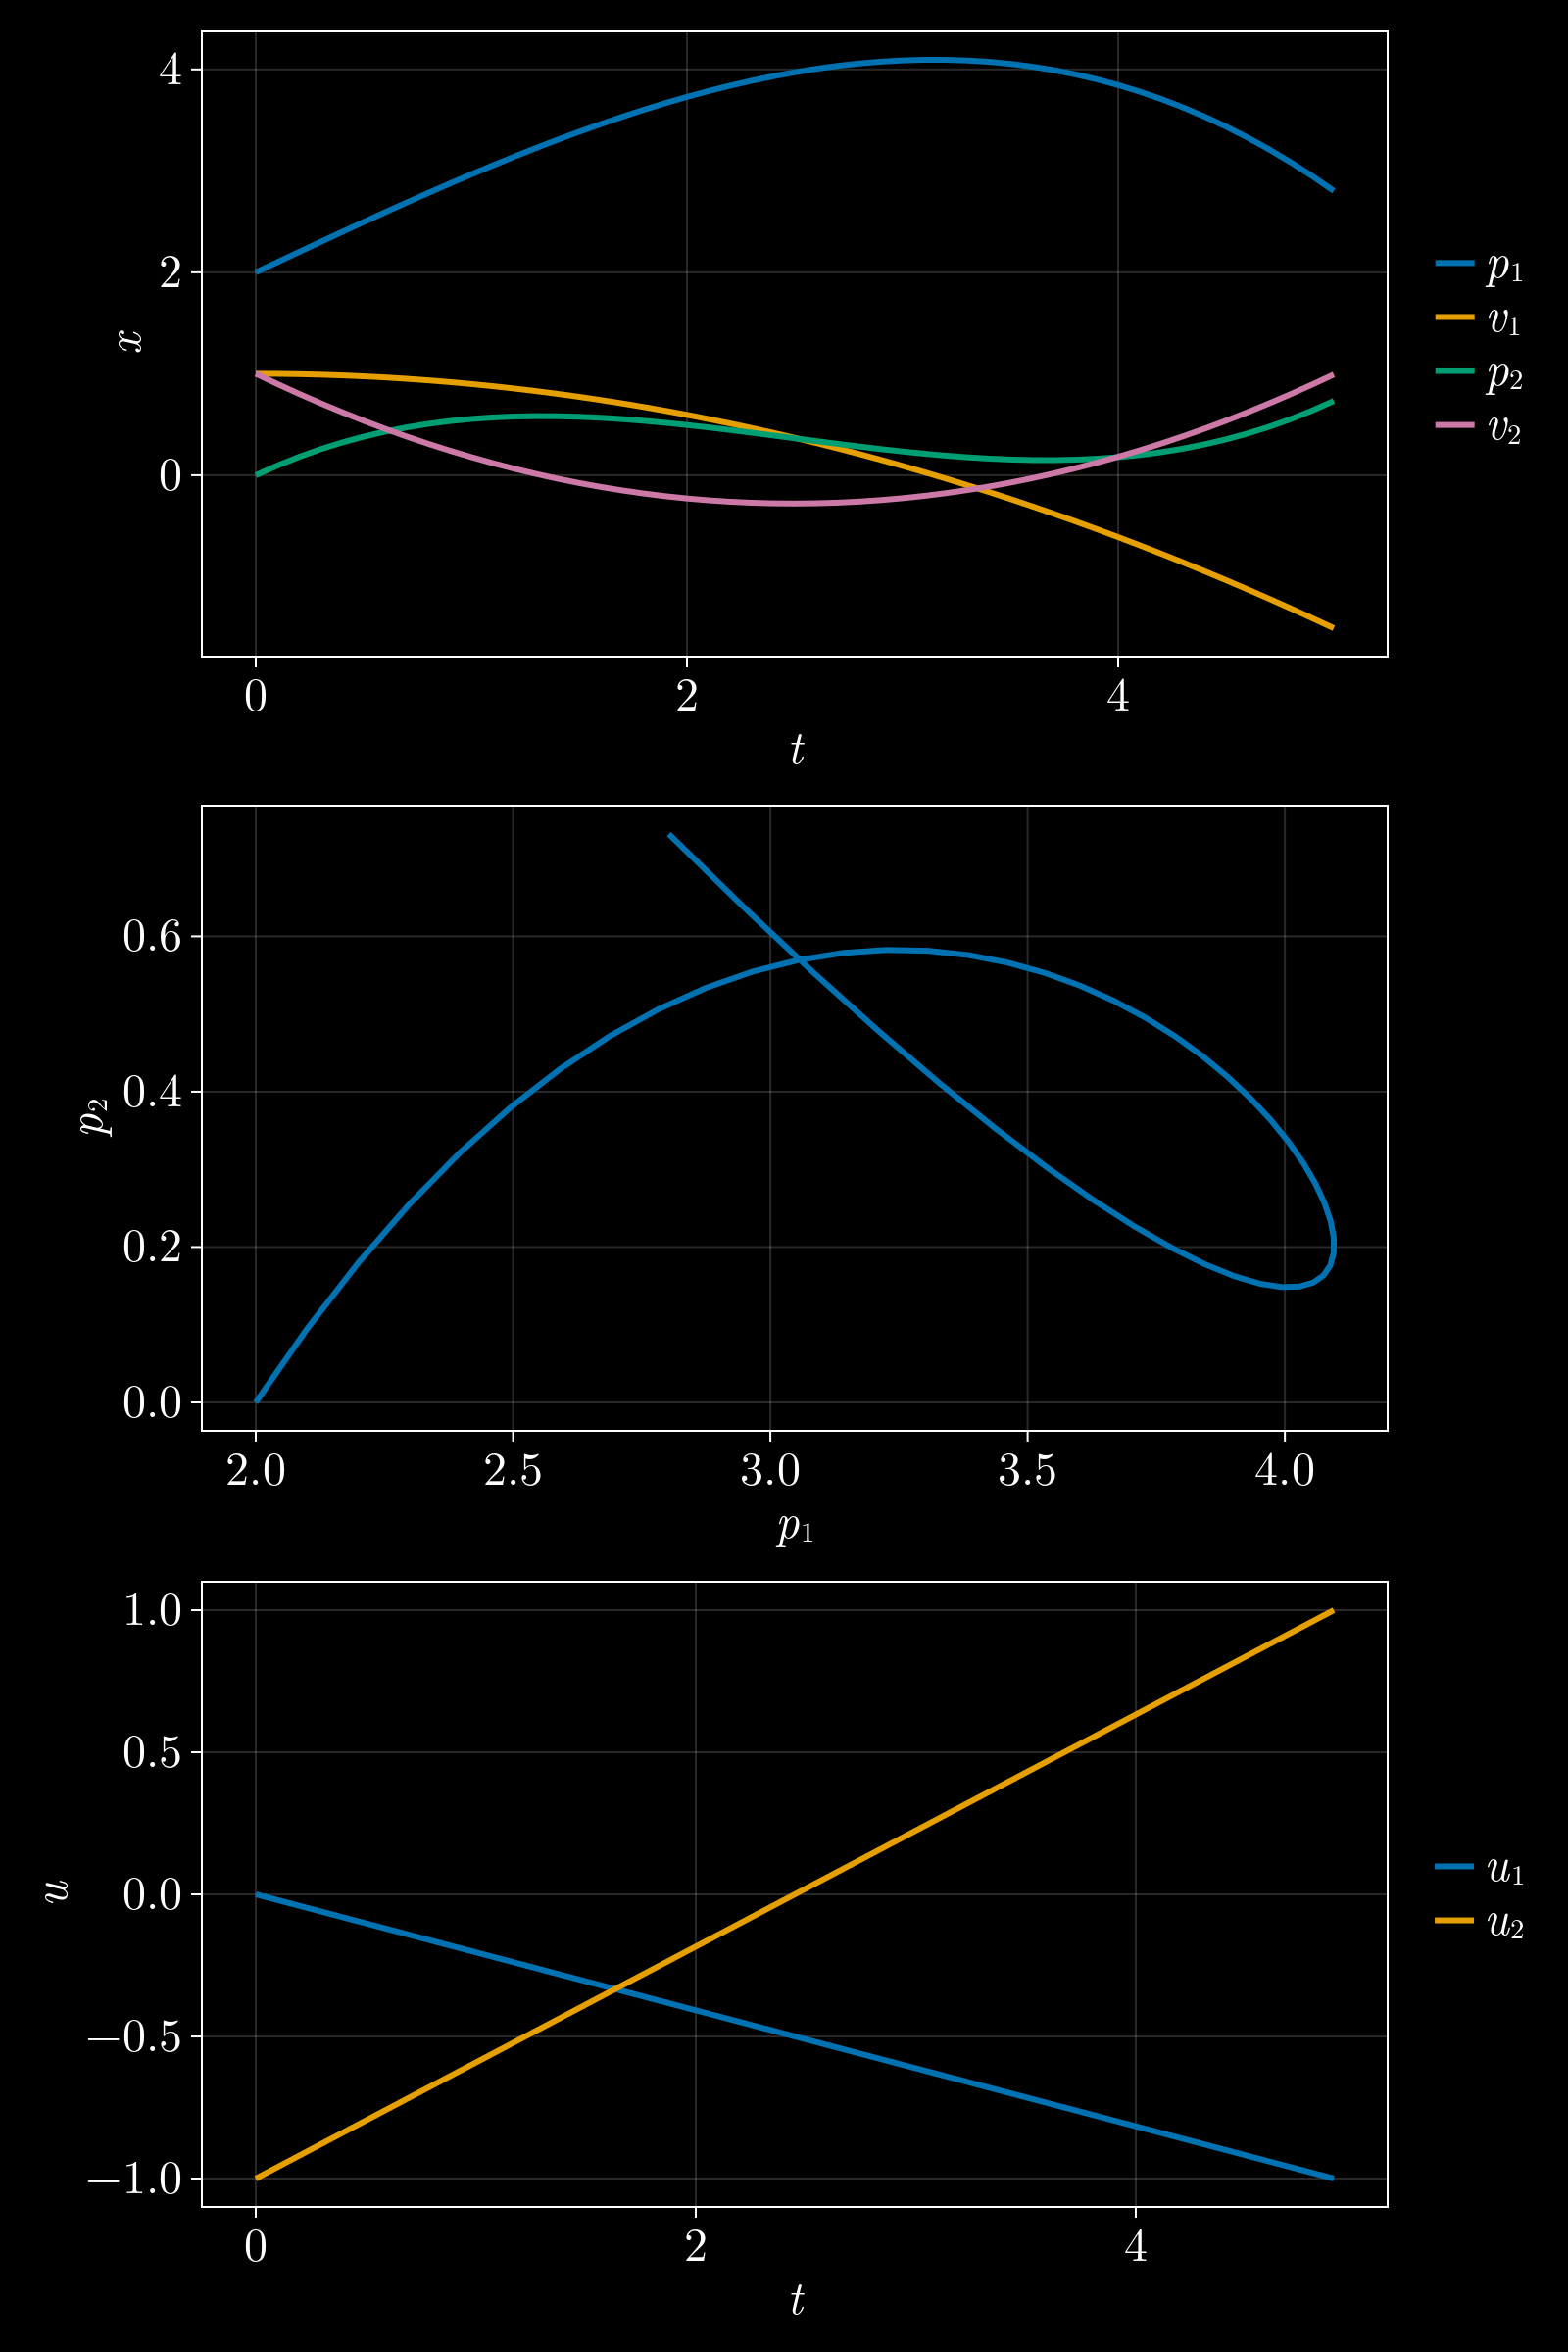

In [6]:
# Plot

# set theme
dark_latexfonts = merge(theme_black(), theme_latexfonts())
set_theme!(dark_latexfonts)

f = Figure(fontsize = 24, size = (800,1200))
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x")
lines!(ax, t, x[1, :], label=L"p_1", linewidth=3)
lines!(ax, t, x[2, :], label=L"v_1", linewidth=3)
lines!(ax, t, x[3, :], label=L"p_2", linewidth=3)
lines!(ax, t, x[4, :], label=L"v_2", linewidth=3)
f[1, 2] = Legend(f, ax, framevisible = false)

ax = Axis(f[2, 1], xlabel = L"p_1", ylabel = L"p_2")
lines!(ax, x[1, :], x[3, :], linewidth=3)

ax = Axis(f[3, 1], xlabel = L"t", ylabel = L"u")
lines!(ax, t[1:end-1], u[1, :], label=L"u_1", linewidth=3)
lines!(ax, t[1:end-1], u[2, :], label=L"u_2", linewidth=3)
f[3, 2] = Legend(f, ax, framevisible = false)
f

As we have seen in the lecture, we can assemble this into a large system that depends on the initial condition $x_0$ and the input trajectory $u_0,\ldots,u_{N-1}$:
$$ \begin{bmatrix} x_0 \\ x_1 \\ x_2 \\ x_3 \\ \vdots \\ x_N \end{bmatrix} = \begin{bmatrix} 0 & 0 & 0 & \cdots & 0 \\ B & 0 & 0 & \cdots & 0 \\ AB & B & 0 & \cdots & 0 \\ A^2B & AB & B & \ddots & 0 \\ \vdots & \vdots & \vdots & \ddots & 0 \\ A^{N-1} B & A^{N-2} B & A^{N-3} B & \cdots & B \end{bmatrix} \begin{bmatrix} u_0 \\ u_1 \\ u_2 \\ \vdots \\ u_{N-1} \end{bmatrix} + \begin{bmatrix} I \\ A \\ A^2 \\ A^3 \\ \vdots \\ A^N \end{bmatrix} x_0, $$
which can be subsumed into
$$ X = G U + H x_0 $$
with $X\in\R^{(N+1)n}$, $U\in\R^{Nm}$, $G\in\R^{(N+1)n \times Nm}$, $H\in\R^{(N+1)n \times n}$.

In [7]:
# Assemble G and H matrices
function assemble_G_and_H(A, B, N)
    n = size(A, 1);    # state dimension
    m = size(B, 2);    # control dimension

    # set up sparse matrices G and H
    G = spzeros((N + 1)*n, N*m);
    H = spzeros((N + 1)*n, n);

    # sparsify A and B
    A = sparse(A);
    B = sparse(B);

    # fill the G and H matrices according to the pattern above
    for i in 2 : N + 1
        for j in 1 : i - 1
            G[(i-1) * n + 1 : i * n, (j-1) * m + 1 : j * m] = A^(i - j - 1) * B;
        end
    end

    for i in 1 : N + 1
        H[(i-1) * n + 1 : i * n, :] = A^(i - 1);
    end

    return G, H
end;

In [8]:
# Compare the solution of the new form to the standard one
G, H = assemble_G_and_H(A, B, N);

# reshape the input matrix into one large vector
U = reshape(u, m * N, 1);

# predict the state
X = G * U + H * x0;

# reshape state prediction into array of size n ⨉ N
x2 = reshape(X, n, N + 1);

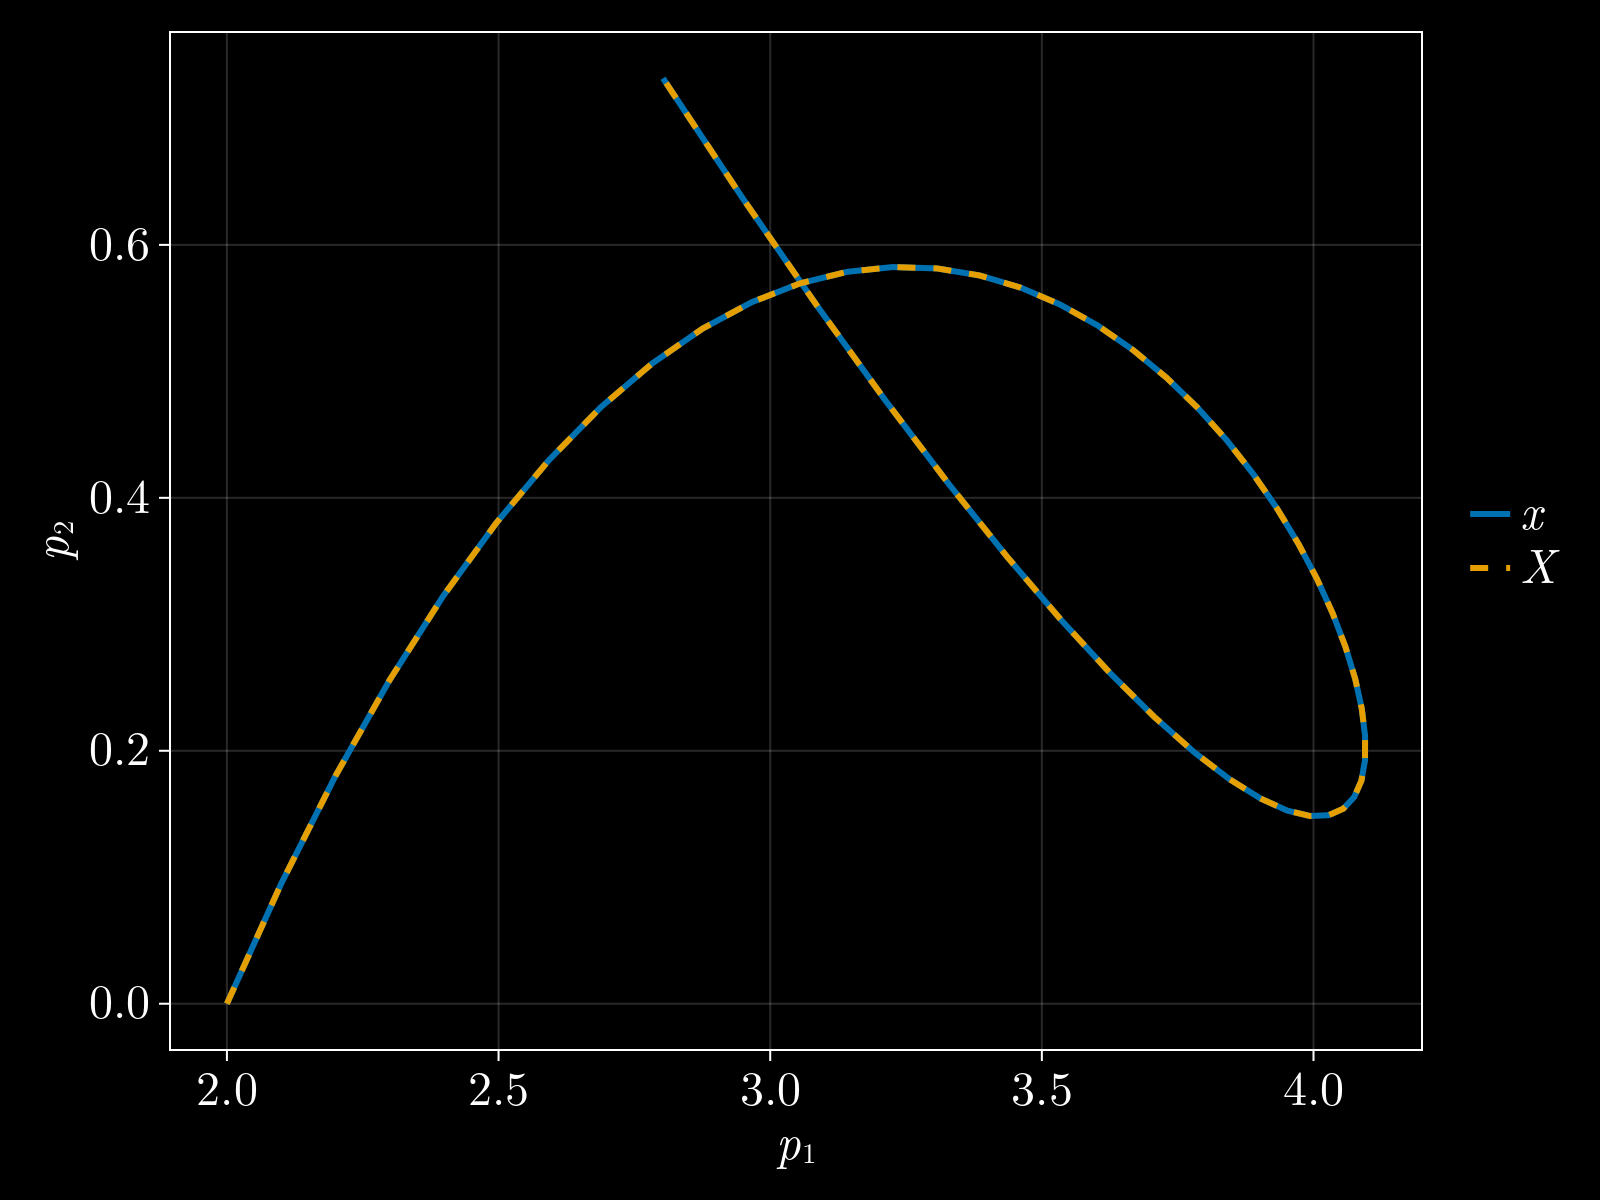

In [9]:
# Plot
f = Figure(fontsize = 24, size = (800,600))
# ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"X")
# lines!(ax, t, x2[1, :], label=L"P_1", linewidth=3)
# lines!(ax, t, x2[2, :], label=L"V_1", linewidth=3)
# lines!(ax, t, x2[3, :], label=L"P_2", linewidth=3)
# lines!(ax, t, x2[4, :], label=L"V_2", linewidth=3)
# f[1, 2] = Legend(f, ax, framevisible = false)

ax = Axis(f[1, 1], xlabel = L"p_1", ylabel = L"p_2")
lines!(ax, x[1, :], x[3, :], label=L"x", linewidth=3)
lines!(ax, x2[1, :], x2[3, :], label=L"X", linewidth=3, linestyle=:dash)
f[1, 2] = Legend(f, ax, framevisible = false)

# ax = Axis(f[3, 1], xlabel = L"t", ylabel = L"U")
# lines!(ax, t[1:end-1], u[1, :], label=L"U_1", linewidth=3)
# lines!(ax, t[1:end-1], u[2, :], label=L"U_2", linewidth=3)
# f[3, 2] = Legend(f, ax, framevisible = false)
f

Now let's define the control problem, where we want to steer the system to the origin $(0,0)$.
$$ J(X,U) = \sum_{k=0}^{N-1} \left( (x[k])^\top Q x[k] + (u[k])^\top R u[k]\right) + (x[N])^\top Q_f x[N] \\ \text{s.t.} \quad x[k+1] = A x[k] + B u[k], $$
where $Q,Q_f\in\R^{n \times n}$ are symmetric and positive semidefinite, and $R\in\R^{m \times m}$ is positive definite.

Following the rephrasing of the dynamics, we can also rephrase the objective function. Using the stacked weight matrices
$$ \hat{Q} = \begin{bmatrix} Q & & & \\ & \ddots & & \\ & & Q & \\ & & & Q_f \end{bmatrix} \in \R^{(N+1)n \times (N+1)n} \quad \text{and} \quad \hat{R} = \begin{bmatrix} R & & \\ & \ddots & \\ & & R \end{bmatrix} \in \R^{Nm \times Nm} $$
we obtain
$$ 
J(U) = X^\top \hat{Q} X + U^\top \hat{R} U  = (GU + Hx_0)^\top \hat{Q} (GU + Hx_0) + U^\top \hat{R} U \\
= (U^\top G^\top + x_0^\top H^\top ) \hat{Q} (GU + Hx_0) + U^\top \hat{R} U \qquad \qquad \\
= U^\top (G^\top \hat{Q} G + \hat{R}) U + 2 U^\top G^\top \hat{Q}^\top H x_0  + x_0^\top H^\top \hat{Q} H x_0.
$$
which has a quadratic term in $U$, a linear term, and a constant term. Thus, taking the derivative, we find
$$ \frac{dJ}{dU} = 2 (G^\top \hat{Q} G + \hat{R}) U + 2 G^\top \hat{Q}^\top H x_0. $$
Setting this to zero leads to a linear system of equations that we need to solve to find the optimal $U^*$:
$$(G^\top \hat{Q} G + \hat{R}) U^* = - G^\top \hat{Q}^\top H x_0.$$

In [10]:
# Assemble Q and R matrices
function assemble_Q_and_R(Q, Qf, R, N)
    n = size(Q, 1);   # state dimension
    m = size(R, 1);   # control dimension

    # create Qhat and Rhat in sparse form
    Qhat = spzeros((N+1)*n, (N+1)*n);
    Rhat = spzeros(N*m, N*m);
    for i in 1 : N
        Qhat[(i-1) * n + 1 : i * n, (i-1) * n + 1 : i * n] = Q
        Rhat[(i-1) * m + 1 : i * m, (i-1) * m + 1 : i * m] = R
    end
    Qhat[N * n + 1 : (N+1) * n, N * n + 1 : (N+1) * n] = Qf

    return Qhat, Rhat
end;

In [11]:
# Now let's solve the optimal control problem

# Set the cost functions:
Q = sparse(diagm([1.0, 0.0, 1.0, 0.0]));  # penalize the position, but not the velocity
Qf = 10 * Q;                              # put a stronger penalty on the final position
R = sparse(diagm([1e-2, 1e-2]));          # put a small penalty on the control input

# Assemble the large cost function matrices
Qhat, Rhat = assemble_Q_and_R(Q, Qf, R, N);

# Solve the linear system to find U*
U_opt = (G' * Qhat * G + Rhat) \ (-G' * Qhat' * H * x0);

# Simulate the system using the optimal input
X_opt = G * U_opt + H * x0;

# Reshape optimal state and control to matrices 
# of dimensions n ⨉ (N + 1) and m ⨉ N, respectively
x_opt = reshape(X_opt, n, N + 1);
u_opt = reshape(U_opt, m, N);

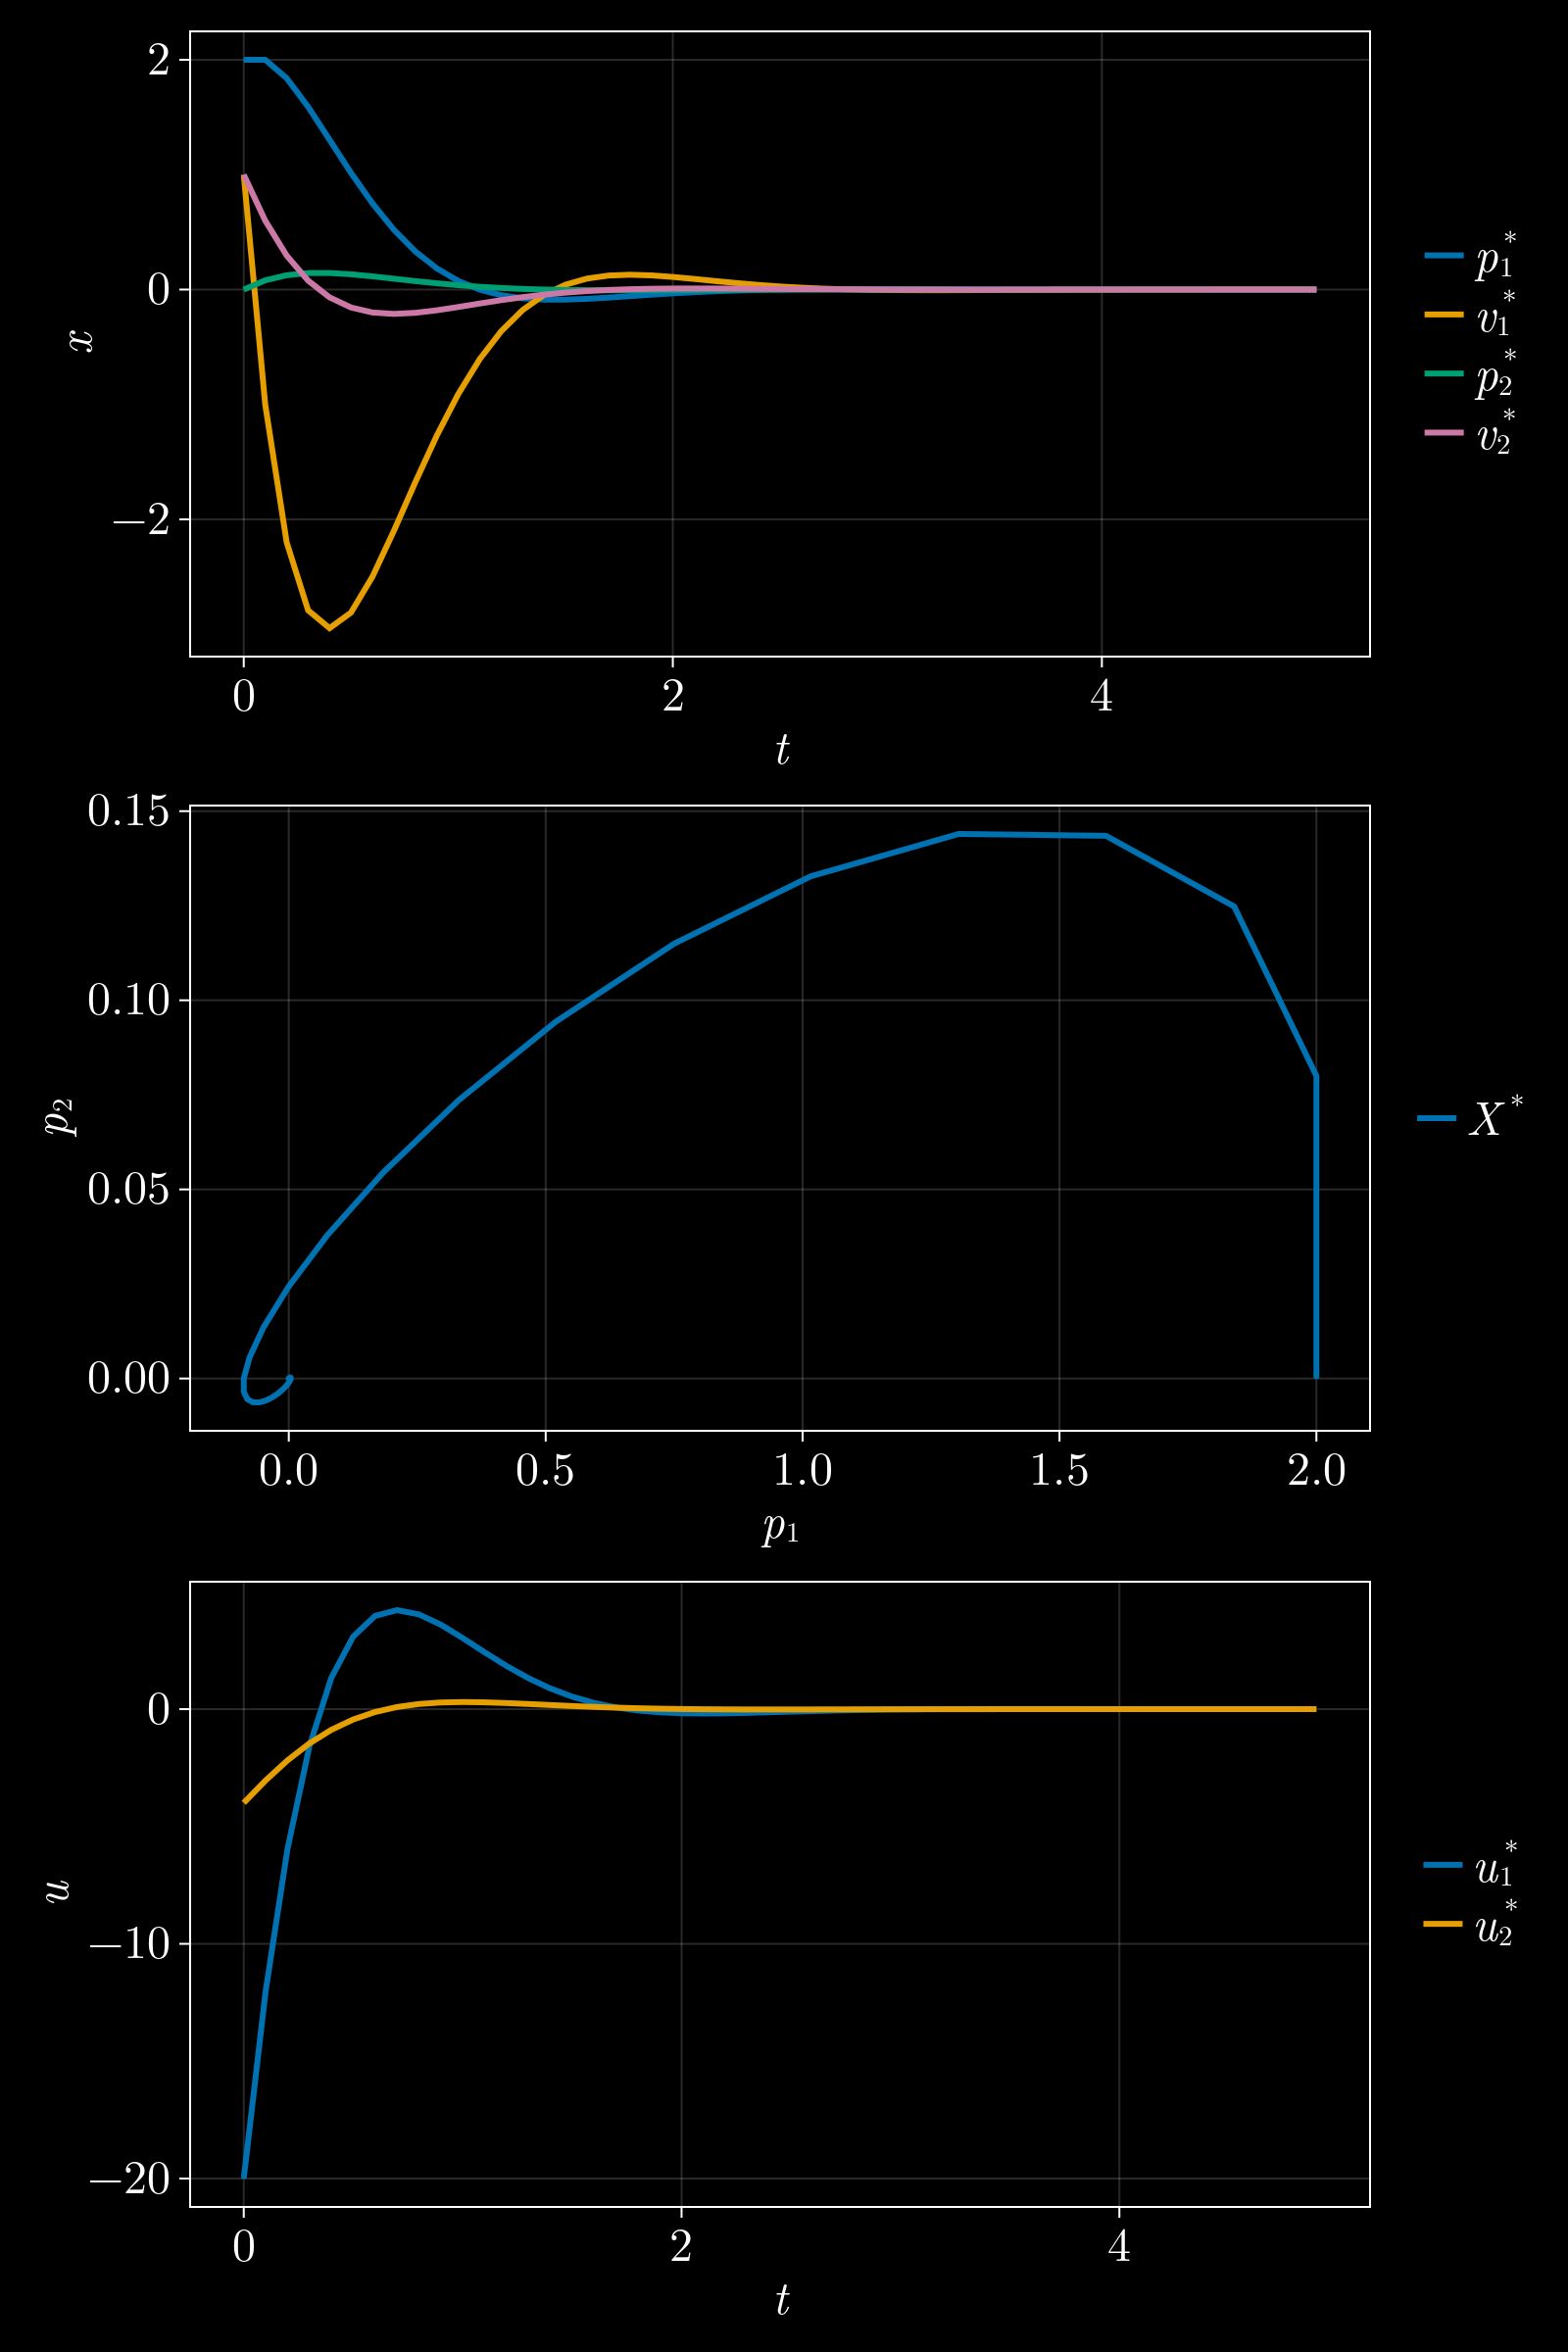

In [12]:
# Plot
f = Figure(fontsize = 24, size = (800,1200))
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x")
lines!(ax, t, x_opt[1, :], label=L"p_1^*", linewidth=3)
lines!(ax, t, x_opt[2, :], label=L"v_1^*", linewidth=3)
lines!(ax, t, x_opt[3, :], label=L"p_2^*", linewidth=3)
lines!(ax, t, x_opt[4, :], label=L"v_2^*", linewidth=3)
f[1, 2] = Legend(f, ax, framevisible = false)

ax = Axis(f[2, 1], xlabel = L"p_1", ylabel = L"p_2")
lines!(ax, x_opt[1, :], x_opt[3, :], label=L"X^*", linewidth=3)
f[2, 2] = Legend(f, ax, framevisible = false)

ax = Axis(f[3, 1], xlabel = L"t", ylabel = L"u")
lines!(ax, t[1:end-1], u_opt[1, :], label=L"u_1^*", linewidth=3)
lines!(ax, t[1:end-1], u_opt[2, :], label=L"u_2^*", linewidth=3)
f[3, 2] = Legend(f, ax, framevisible = false)
f

## Model Predictive Control (MPC)

We now realize a feedback controller using MPC, where we initialize the control problem with the current system state ($x_0 = x[k]$). We then solve the open loop problem for $N_p$ prediction steps and apply the first entry of $u^*$ to the real system.

To make things more interesting, we will introduce a time-dependent reference trajectory $x_{ref}(t)$:
$$ J(X,U) = \sum_{k=0}^{N-1} \left( (x[k] - x_{ref}[k])^\top Q (x[k] - x^{ref}[k]) + (u[k])^\top R u[k]\right) \\ + (x[N] - x_{ref}[N])^\top Q_f (x[N] - x_{ref}[N]) \\ \text{s.t.} \quad x[k+1] = A x[k] + B u[k], $$

Arranging the reference trajectory into a large vector of size $X_{ref}\in\R^{(N+1)n}$, we obtain a slightly more complicated loss function:
$$ 
J(U) = \left(X-X_{ref}\right)^\top \hat{Q} \left(X-X_{ref}\right) + U^\top \hat{R} U \\ = (GU + Hx_0-X_{ref})^\top \hat{Q} (GU + Hx_0-X_{ref}) + U^\top \hat{R} U \\
= (U^\top G^\top + x_0^\top H^\top -X_{ref}^\top) \hat{Q} (GU + Hx_0 -X_{ref}) + U^\top \hat{R} U \qquad \qquad \\
= U^\top (G^\top \hat{Q} G + \hat{R}) U + 2 U^\top G^\top \hat{Q}^\top (H x_0-X_{ref}) \\ + (x_0^\top H^\top-X_{ref}^\top) \hat{Q} (H x_0-X_{ref}).
$$
which has a quadratic term in $U$, a linear term, and a constant term. Thus, taking the derivative, we find
$$ \frac{dJ}{dU} = 2 (G^\top \hat{Q} G + \hat{R}) U + 2 G^\top \hat{Q}^\top (H x_0-X_{ref}). $$
Setting this to zero leads to a linear system of equations that we need to solve to find the optimal $U^*$:
$$(G^\top \hat{Q} G + \hat{R}) U^* = - G^\top \hat{Q}^\top (H x_0-X_{ref}).$$

In [13]:
# prediction horizon
N_MPC = 500;            # number of time steps
T_MPC = N_MPC * dt;     # final time

# initial condition
x0_MPC = [0; 0; 0; 0]; 

# time array
t_MPC = LinRange(0, T_MPC, N_MPC + 1)

# reference trajectory
# We want to follow an ellipse whose radius increases 
# slowly from 1/2 to 2/4 over the time horizon
x_ref = zeros(n, N_MPC + 1)
x_ref[1, :] = (1 .+ t_MPC / 25) .* cos.(2 * pi / 5 * t_MPC)
x_ref[3, :] = (2 .+ t_MPC / 5) .* sin.(2 * pi / 5 * t_MPC);

In [14]:
# MPC algorithm
N_p = 10

# Set the cost functions:
Q_MPC = sparse(diagm([1.0, 0.0, 1.0, 0.0]));  # penalize the position, but not the velocity
Qf_MPC = 1 * Q_MPC;                           # put same penalty on the final position
R_MPC = sparse(diagm([1e-3, 1e-3]));          # put a small penalty on the control input

# Open loop problem over prediction horizon of length N_p
G_MPC, H_MPC = assemble_G_and_H(A, B, N_p);
Qhat_MPC, Rhat_MPC = assemble_Q_and_R(Q_MPC, Qf_MPC, R_MPC, N_p);

k = 1

x_MPC = zeros(4, N_MPC + 1)
x_MPC[:, 1] = x0_MPC
u_MPC = zeros(2, N_MPC)
while k < N_MPC - N_p

    # reference trajectory for current open loop problem
    x_ref_k = reshape(x_ref[:, k : k + N_p], (N_p + 1) * n, 1)[:, 1]

    # solve open loop problem for N_p prediction steps
    U_opt_k = (G_MPC' * Qhat_MPC * G_MPC + Rhat_MPC) \ 
            (-G_MPC' * Qhat_MPC' * (H_MPC * x_MPC[:, k] - x_ref_k));

    # apply first entry to real system
    u_MPC[:, k] = U_opt_k[1 : 2]
    x_MPC[:, k + 1] = A * x_MPC[:, k] + B * u_MPC[:, k]

    # increase k
    k += 1
end

# cut trajectories (we have to stop early due to the prediction horizon)
x_MPC = x_MPC[:, 1 : end - N_p - 2]
u_MPC = u_MPC[:, 1 : end - N_p - 1]

# time array
t_MPC = LinRange(0, T_MPC, N_MPC + 1)
t_MPC = t_MPC[1 : end - N_p - 2];

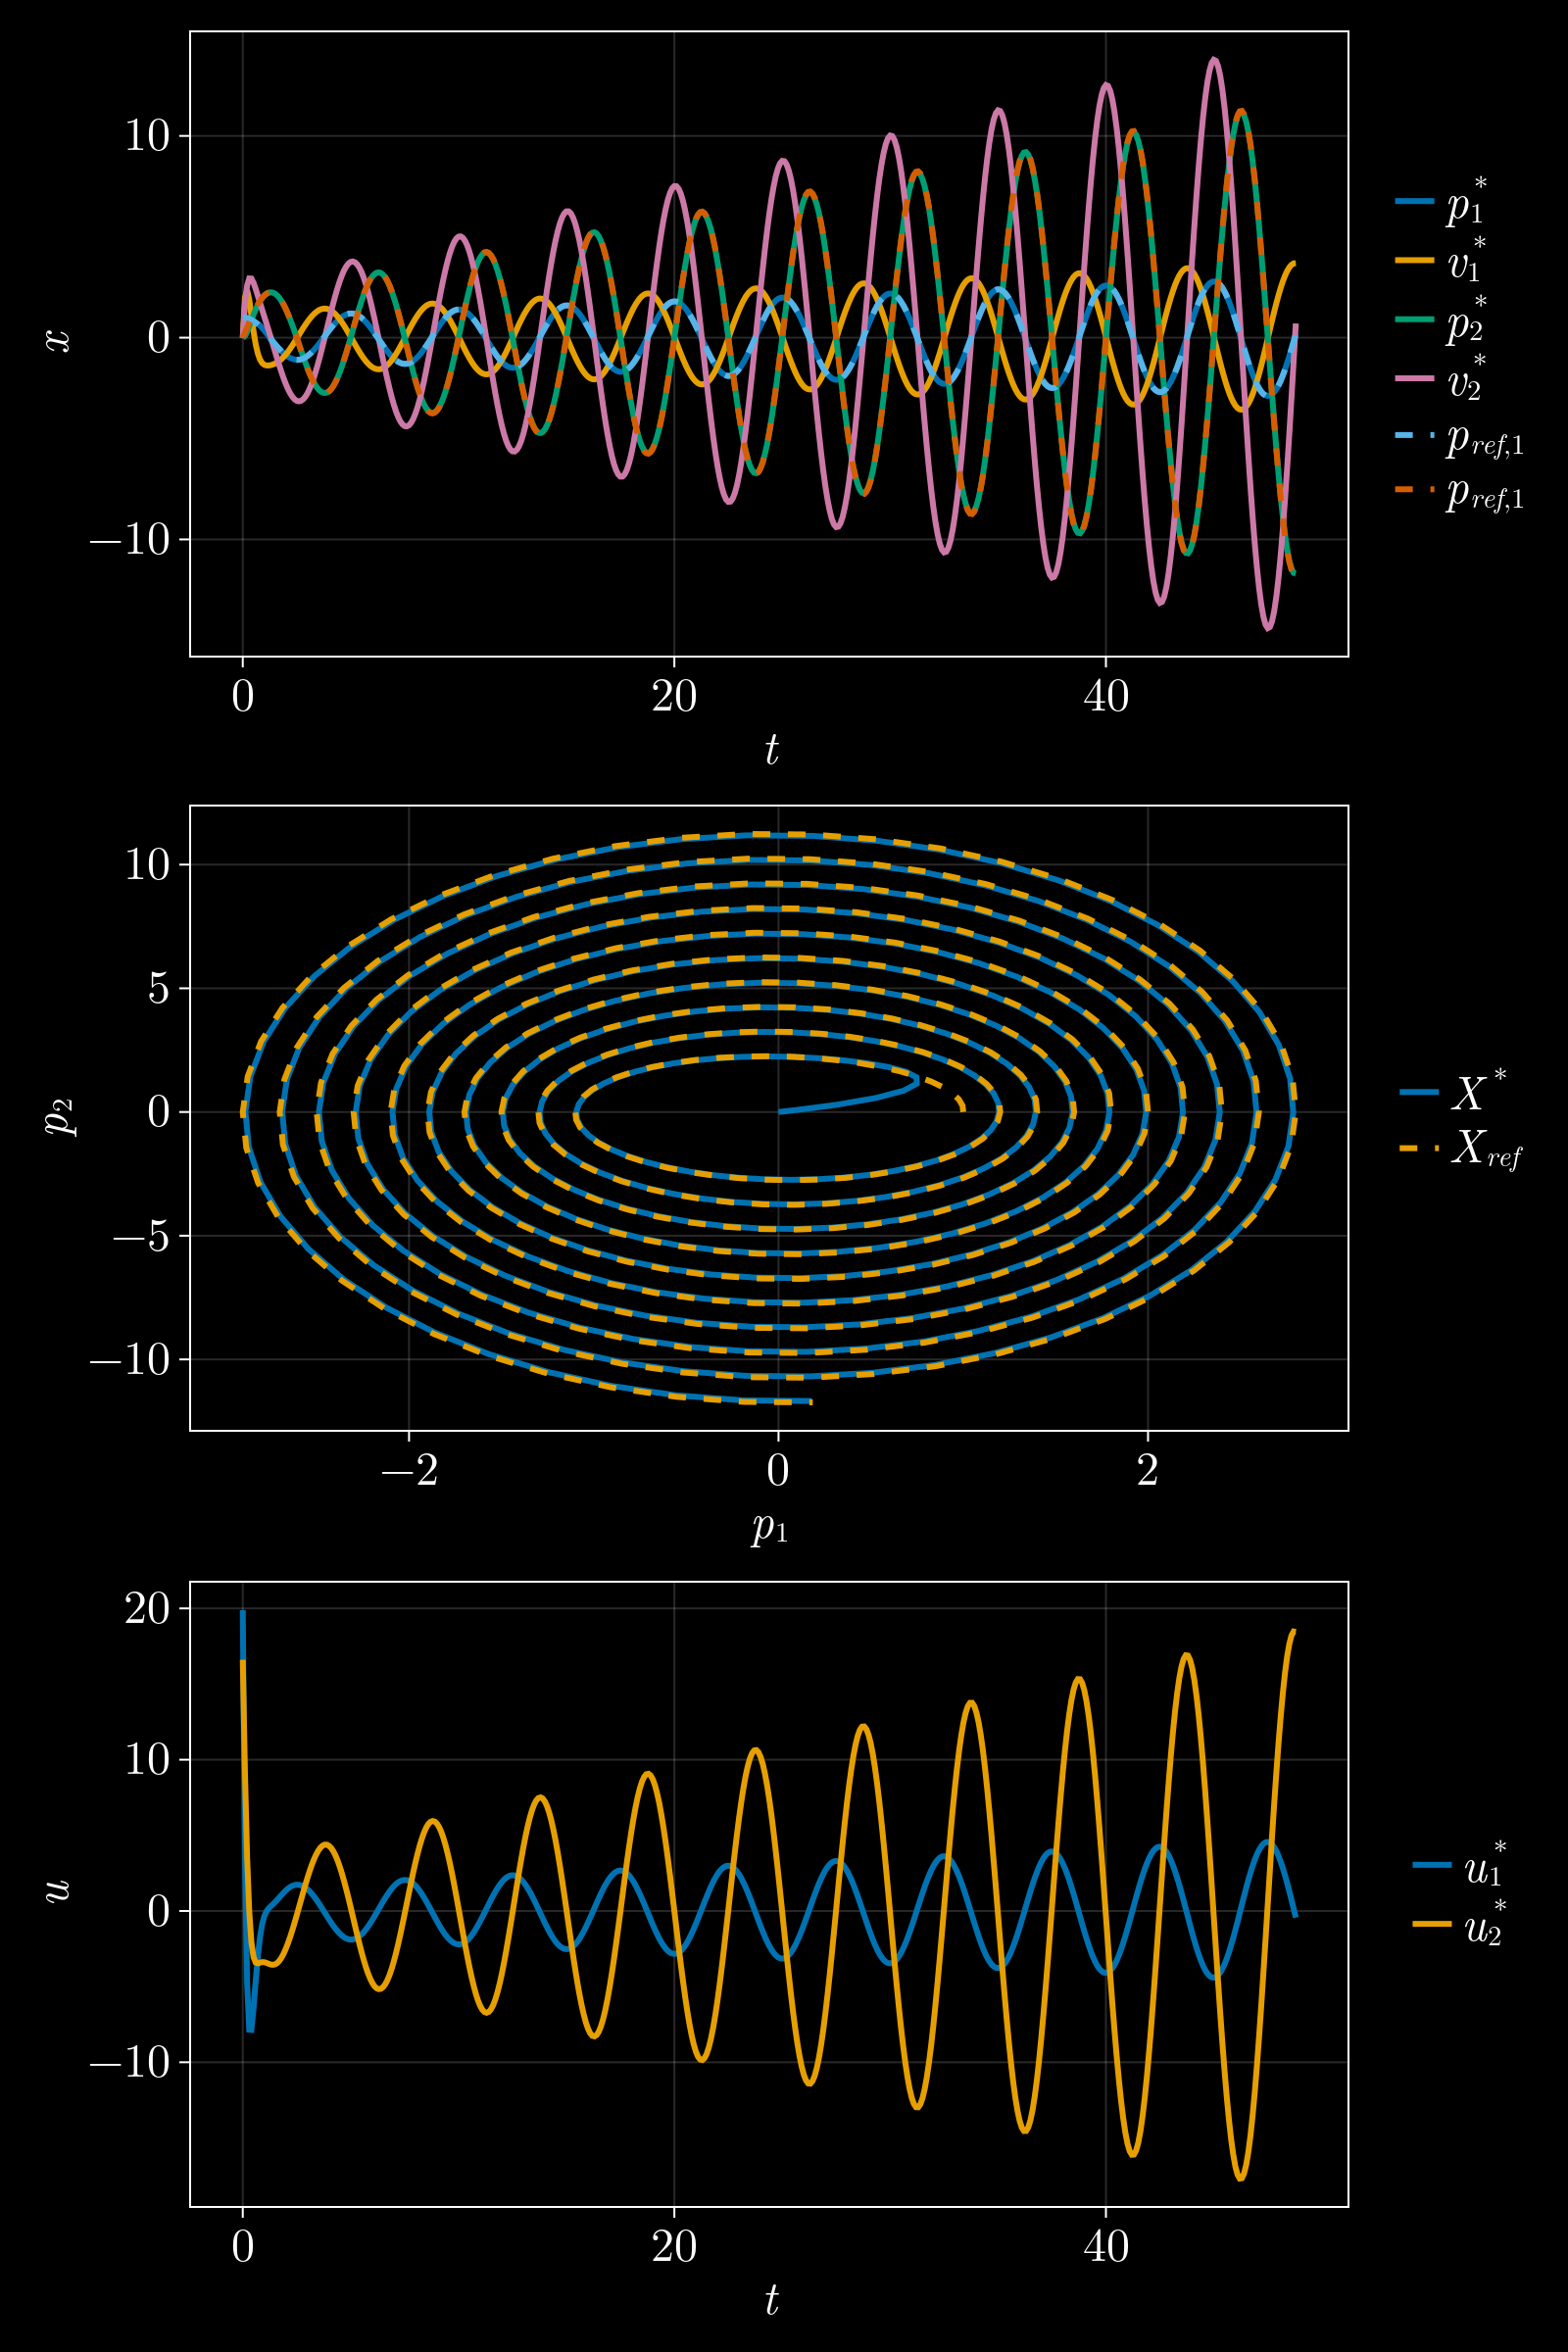

In [15]:
# Plot
f = Figure(fontsize = 24, size = (800,1200))
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x")
lines!(ax, t_MPC, x_MPC[1, :], label=L"p_1^*", linewidth=3)
lines!(ax, t_MPC, x_MPC[2, :], label=L"v_1^*", linewidth=3)
lines!(ax, t_MPC, x_MPC[3, :], label=L"p_2^*", linewidth=3)
lines!(ax, t_MPC, x_MPC[4, :], label=L"v_2^*", linewidth=3)
lines!(ax, t_MPC, x_ref[1, 1 : end - N_p - 2], label=L"p_{ref,1}", linewidth=3, linestyle=:dash)
lines!(ax, t_MPC, x_ref[3, 1 : end - N_p - 2], label=L"p_{ref,1}", linewidth=3, linestyle=:dash)
f[1, 2] = Legend(f, ax, framevisible = false)

ax = Axis(f[2, 1], xlabel = L"p_1", ylabel = L"p_2")
lines!(ax, x_MPC[1, :], x_MPC[3, :], label=L"X^*", linewidth=3)
lines!(ax, x_ref[1, 1 : end - N_p - 2], x_ref[3, 1 : end - N_p - 2], label=L"X_{ref}", linewidth=3, linestyle=:dash)
f[2, 2] = Legend(f, ax, framevisible = false)

ax = Axis(f[3, 1], xlabel = L"t", ylabel = L"u")
lines!(ax, t_MPC, u_MPC[1, :], label=L"u_1^*", linewidth=3)
lines!(ax, t_MPC, u_MPC[2, :], label=L"u_2^*", linewidth=3)
f[3, 2] = Legend(f, ax, framevisible = false)
f

## Using Dynamic Mode Decomposition with Control to control a nonlinear system
Let's consider the *Duffing Oscillator*
$$ \ddot{x}(t) + \delta \dot{x}(t) + \alpha x(t) + \beta x^3(t) = u(t), $$
with $\alpha=1$, $\beta=-1$ and $\delta=0.5$.

Introducing $x_1 = x$ and $x_2 = \dot{x}$, we get
$$ \frac{d}{dt} \begin{pmatrix} x_1(t) \\ x_2(t) \end{pmatrix} = \begin{pmatrix} x_2(t) \\ -\delta x_2(t) -\alpha x_1(t) - \beta x_1^3(t) + u(t) \end{pmatrix}. $$

In [16]:
function rhs(x, u)
    ɑ, β, δ = -1, 1, 0.1
    xdot = [x[2]; - δ * x[2] - ɑ * x[1] - β * x[1]^3 + u];
    return xdot
end

function rk4(x0, u, dt, N)
    x = zeros(length(x0), N)
    x[:, 1] = x0
    for i = 1 : N - 1
        k1 = rhs(x[:, i], u[i])
        k2 = rhs(x[:, i] + 0.5 * dt * k1, u[i])
        k3 = rhs(x[:, i] + 0.5 * dt * k2, u[i])
        k4 = rhs(x[:, i] + dt * k3, u[i])
        x[:, i + 1] = x[:, i] + dt / 6 * (k1 + 2 * (k2 + k3) + k4)
    end
    return x
end;

In [17]:
x0 = [1; 0.5]
dt = 0.01
N = 10000
T = N*dt

t = LinRange(0, T, N + 1)

u1 = zeros(N + 1)
x1 = rk4(x0, u1, dt, N)

u2 = sin.(t)
x2 = rk4(x0, u2, dt, N);

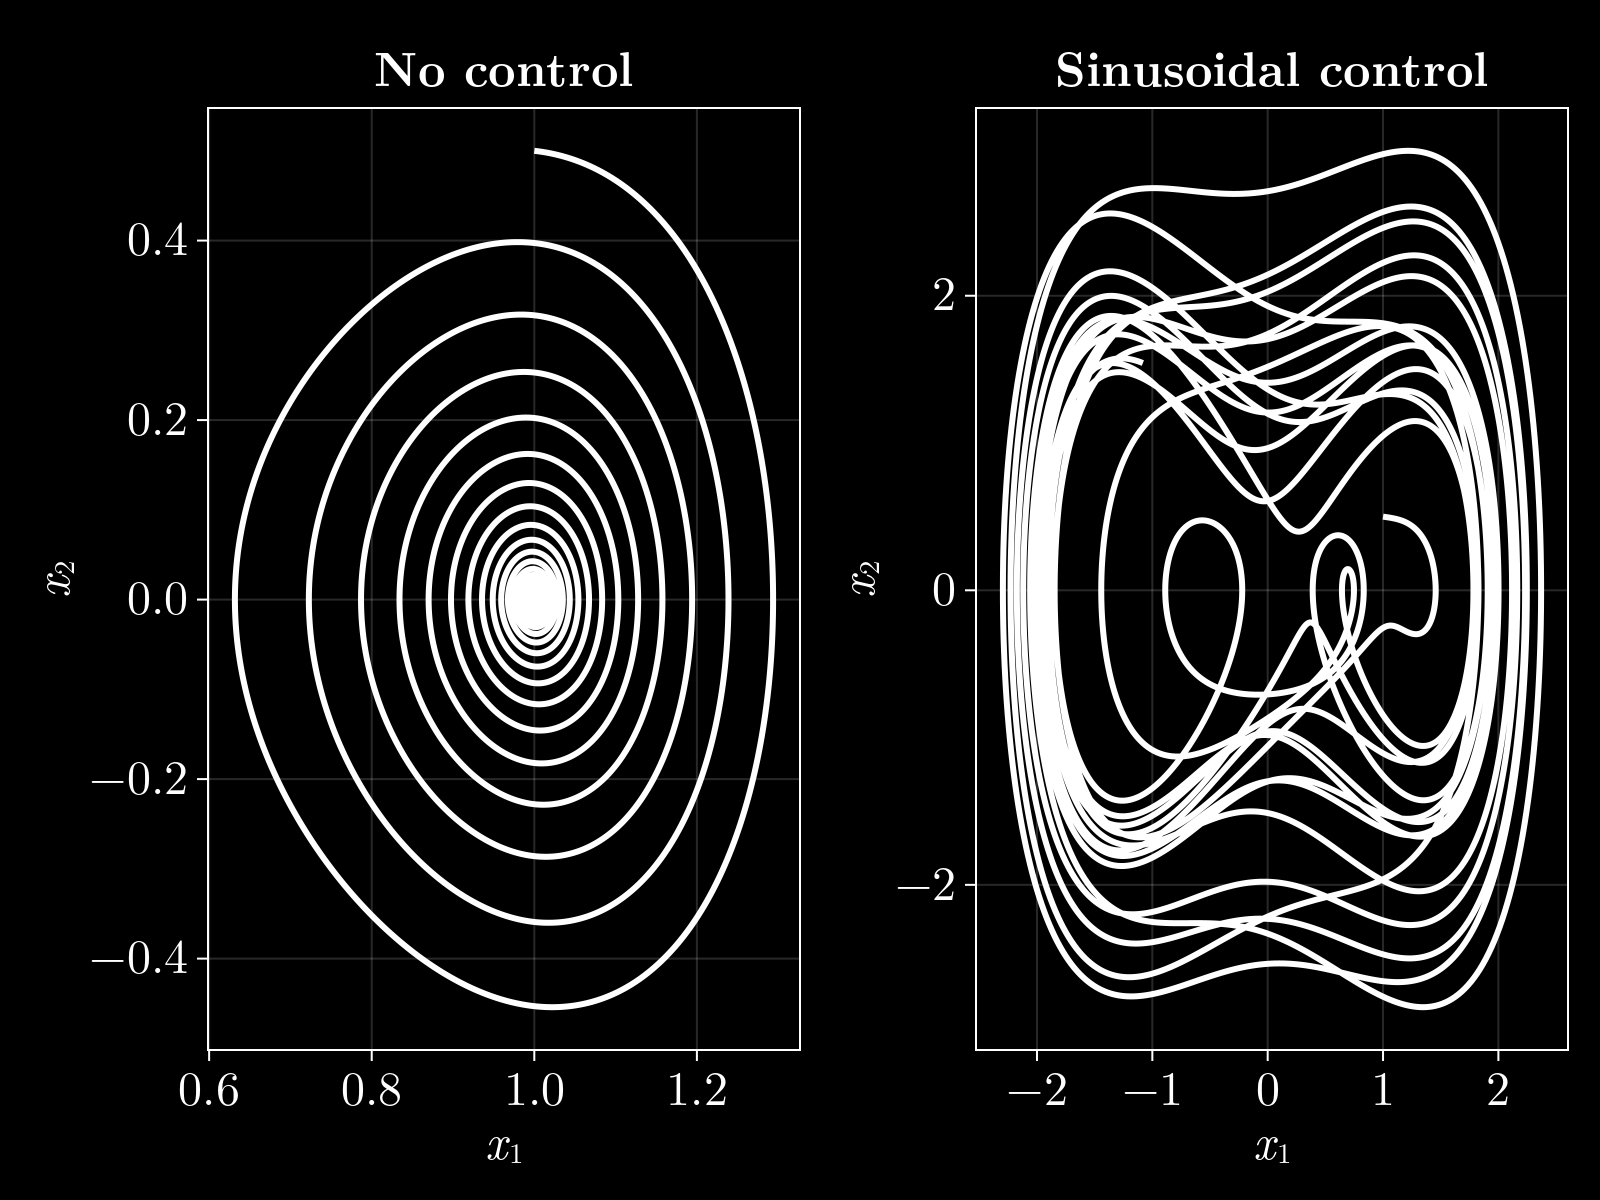

In [18]:
# Plot

fig = Figure(fontsize = 24, size=(800,600))
ax1 = Axis(fig[1, 1], xlabel = L"x_1", ylabel = L"x_2", title="No control")
lines!(ax1, x1[1, :], x1[2, :], color="white", linewidth=3)

ax1 = Axis(fig[1, 2], xlabel = L"x_1", ylabel = L"x_2", title="Sinusoidal control")
lines!(ax1, x2[1, :], x2[2, :], color="white", linewidth=3)

fig

Due to the nonlinear term, we cannot simply implement an MPC algorithm as before. However, we can try to learn a linear system using the following regression problem:
$$ \min_{A\in\R^{q\times q},B\in\R^{q \times m}} \sum_{k=1}^{N-1} \left \| \Psi(x[k + 1]) - (A \Psi(x[k]) + B u[k]) \right\|_2^2,$$
where $\Psi:\R^n \rightarrow \R^q$ is a nonlinear feature transformation of the state $x$, e.g., using monomials.

If we slightly rephrase this and write $C = \begin{bmatrix} A & B \end{bmatrix}\in\R^{q \times (q + m)}$, then this is simply a multivariate OLS problem as before:
$$ \min_{C\in\R^{q \times (q + m)}} \sum_{k=1}^{N-1} \left \| \Psi(x[k + 1]) - C \begin{bmatrix} \Psi(x[k]) \\ u[k] \end{bmatrix} \right\|_2^2. $$

This is known as the *(Extended) Dynamic Mode Decomposition with control*, see [Proctor et al. "Dynamic Mode Decomposition with Control." SIAM Journal on Applied Dynamical Systems, 2016](https://doi.org/10.1137/15M1013857).

For the usage within MPC, we will follow the concept presented in [Korda and Mezic. "Linear predictors for nonlinear dynamical systems: Koopman operator meets model predictive control." Automatica, 2018](https://doi.org/10.1016/j.automatica.2018.03.046).

In [19]:
# hand-crafted polynomial basis until degree 3
function Psi(z, deg=3)
    N = size(z, 2)

    if deg==2
        psiz = zeros(N, 6)
    elseif deg==3
        psiz = zeros(N, 10)
    elseif deg==4
        psiz = zeros(N, 15)
    end
    
    psiz[:, 1] .= 1
    psiz[:, 2] = z[1, :]
    psiz[:, 3] = z[2, :]

    psiz[:, 4] = z[1, :] .* z[1, :]
    psiz[:, 5] = z[1, :] .* z[2, :]
    psiz[:, 6] = z[2, :] .* z[2, :]

    if deg==2
        return psiz
    end

    psiz[:, 7] = z[1, :] .* z[1, :] .* z[1, :]
    psiz[:, 8] = z[1, :] .* z[1, :] .* z[2, :]
    psiz[:, 9] = z[1, :] .* z[2, :] .* z[2, :]
    psiz[:, 10] = z[2, :] .* z[2, :] .* z[2, :]

    if deg==3
        return psiz
    end

    psiz[:, 11] = z[1, :] .* z[1, :] .* z[1, :] .* z[1, :]
    psiz[:, 12] = z[1, :] .* z[1, :] .* z[1, :] .* z[2, :]
    psiz[:, 13] = z[1, :] .* z[1, :] .* z[2, :] .* z[2, :]
    psiz[:, 14] = z[1, :] .* z[2, :] .* z[2, :] .* z[2, :]
    psiz[:, 15] = z[2, :] .* z[2, :] .* z[2, :] .* z[2, :]

    return psiz

end;

# same function, but for a single data point
function Psi1(z, deg=3)

    if deg==2
        psiz = zeros(6)
    elseif deg==3
        psiz = zeros(10)
    elseif deg==4
        psiz = zeros(15)
    end
    
    psiz[1] = 1
    psiz[2] = z[1]
    psiz[3] = z[2]

    psiz[4] = z[1] * z[1]
    psiz[5] = z[1] * z[2]
    psiz[6] = z[2] * z[2]

    if deg==2
        return psiz
    end

    psiz[7] = z[1] * z[1] * z[1]
    psiz[8] = z[1] * z[1] * z[2]
    psiz[9] = z[1] * z[2] * z[2]
    psiz[10] = z[2] * z[2] * z[2]

    if deg==3
        return psiz
    end

    psiz[11] = z[1] * z[1] * z[1] * z[1]
    psiz[12] = z[1] * z[1] * z[1] * z[2]
    psiz[13] = z[1] * z[1] * z[2] * z[2]
    psiz[14] = z[1] * z[2] * z[2] * z[2]
    psiz[15] = z[2] * z[2] * z[2] * z[2]

    return psiz

end;

We now perform the following steps:

* collect data tuples $\{(x[k], u[k], x[k+1])\}_{k=1}^{N_{data}-1}$
* lift $x[k]$ to $\Psi(x[k])$, $k=1,\ldots,N_{data}$
* solve the multivariate OLS problem

In [20]:
Ndata = 10000
x = zeros(Ndata, 2)
u = zeros(Ndata, 1)
y = zeros(Ndata, 2)
for k in 1 : Ndata

    # random sampling of data
    x[k, 1] = -2 .+ 4 .* rand()
    x[k, 2] = -1 .+ 2 .* rand()
    u[k, 1] = -1 + 2 * rand()

    # prediction under dymamics
    y[k, :] = rk4(x[k, :], u[k, 1], dt, 2)[:, 2]
end

# lift data
PsiZ = Psi(x')

# determine size of lifted system
nPsi = size(PsiZ, 2)

Z = zeros(Ndata, nPsi + 1)
Z[:, 1 : end - 1] = PsiZ
Z[:, end] = u

PsiY = Psi(y')

# solve the multivariate regression problem
C = inv(Z' * Z) * Z' * PsiY;

# separate C into A and B
A = C[1 : end - 1, :];
B = C[end, :];

println(size(A))
println(size(B))

(10, 10)
(10,)


In [21]:
# Compare identified model against true solution (very poor!)
x1_DMDc = zeros(nPsi, N)
x2_DMDc = zeros(nPsi, N)

x1_DMDc[:, 1] = Psi(x1)[1, :]
x2_DMDc[:, 1] = Psi(x2)[1, :]

for k in 1 : N - 1
    x1_DMDc[:, k + 1] = A * x1_DMDc[:, k] + B * u1[k]
    x2_DMDc[:, k + 1] = A * x2_DMDc[:, k] + B * u2[k]
end

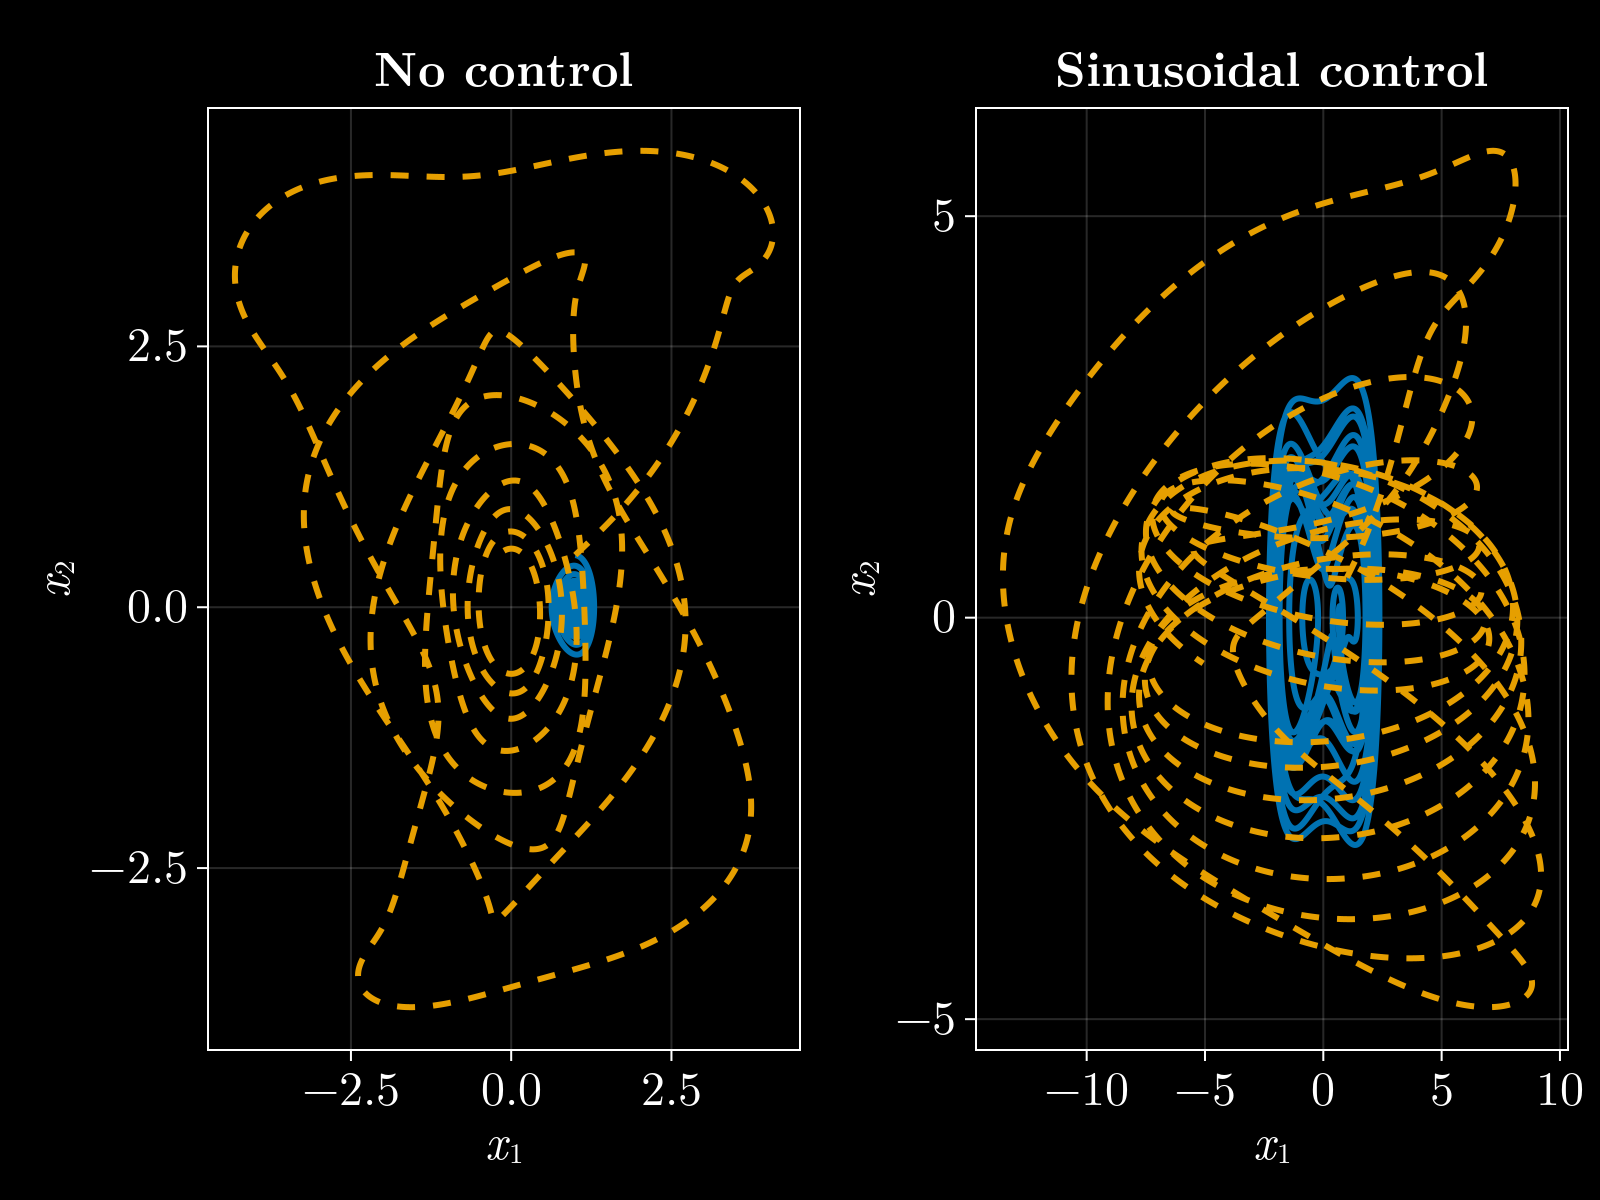

In [22]:
# Plot

fig = Figure(fontsize = 24, size=(800,600))
ax1 = Axis(fig[1, 1], xlabel = L"x_1", ylabel = L"x_2", title="No control")
lines!(ax1, x1[1, :], x1[2, :], linewidth=3)
lines!(ax1, x1_DMDc[2, :], x1_DMDc[3, :], linewidth=3, linestyle=:dash)

ax1 = Axis(fig[1, 2], xlabel = L"x_1", ylabel = L"x_2", title="Sinusoidal control")
lines!(ax1, x2[1, :], x2[2, :], linewidth=3)
lines!(ax1, x2_DMDc[2, :], x2_DMDc[3, :], linewidth=3, linestyle=:dash)

fig

Since the open loop prediction is terrible, let's use the model in an MPC loop, which is good at correcting for errors. To this end, we

* Measure the current state $x[k]$ from the real system
* Lift $x[k]$ to $\Psi(x[k])$
* Solve the Open Loop problem over $N_p$ time steps using the linear DMDc model (i.e., using $A$ and $B$)
* Use the identified $u^*$ and apply the first step to the real system (here, the RK4 integrator)

In [23]:
# prediction horizon
N_MPC = 2000;            # number of time steps
T_MPC = N_MPC * dt;     # final time

# time array
t_MPC = LinRange(0, T_MPC, N_MPC + 1)

# reference trajectory
# We want to follow go to the unstable origin [0, 0]
x_ref = zeros(n, N_MPC + 1)

# MPC algorithm
N_p = 10

# Set the cost functions. Just penalize the first-order terms in the polynomial
# these are located a indices 2 and 3 (index 1 is the bias term)
Q_MPC = sparse(diagm([0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]));
Qf_MPC = 1 * Q_MPC;
R_MPC = sparse(diagm([1e-2]));

# Open loop problem over prediction horizon of length N_p
G_MPC, H_MPC = assemble_G_and_H(A, B, N_p);
Qhat_MPC, Rhat_MPC = assemble_Q_and_R(Q_MPC, Qf_MPC, R_MPC, N_p);

# Now let's run the MPC loop
k = 1

# initialize state and control trajectory arrays
x_MPC = zeros(2, N_MPC + 1)
x_MPC[:, 1] = x0
u_MPC = zeros(N_MPC)
while k < N_MPC - N_p

    # reference trajectory for current open loop problem
    # Lifted to Psi space
    x_ref_k = reshape(Psi(x_ref[:, k : k + N_p]), (N_p + 1) * nPsi, 1)[:, 1]

    # solve open loop problem for N_p prediction steps
    # with lifted initial condition and lifted reference trajectory
    U_opt_k = (G_MPC' * Qhat_MPC * G_MPC + Rhat_MPC) \ (-G_MPC' * Qhat_MPC' * (H_MPC * Psi1(x_MPC[:, k]) - x_ref_k));

    # apply first entry to real system (RK4 integrator)
    u_MPC[k] = U_opt_k[1]
    x_MPC[:, k + 1] =rk4(x_MPC[:, k], u_MPC[k], dt, 2)[:, 2]

    # increase k
    k += 1
end

# cut trajectories (we have to stop early due to the prediction horizon)
x_MPC = x_MPC[:, 1 : end - N_p - 2]
u_MPC = u_MPC[1 : end - N_p - 1]

# time array
t_MPC = LinRange(0, T_MPC, N_MPC + 1)
t_MPC = t_MPC[1 : end - N_p - 2];

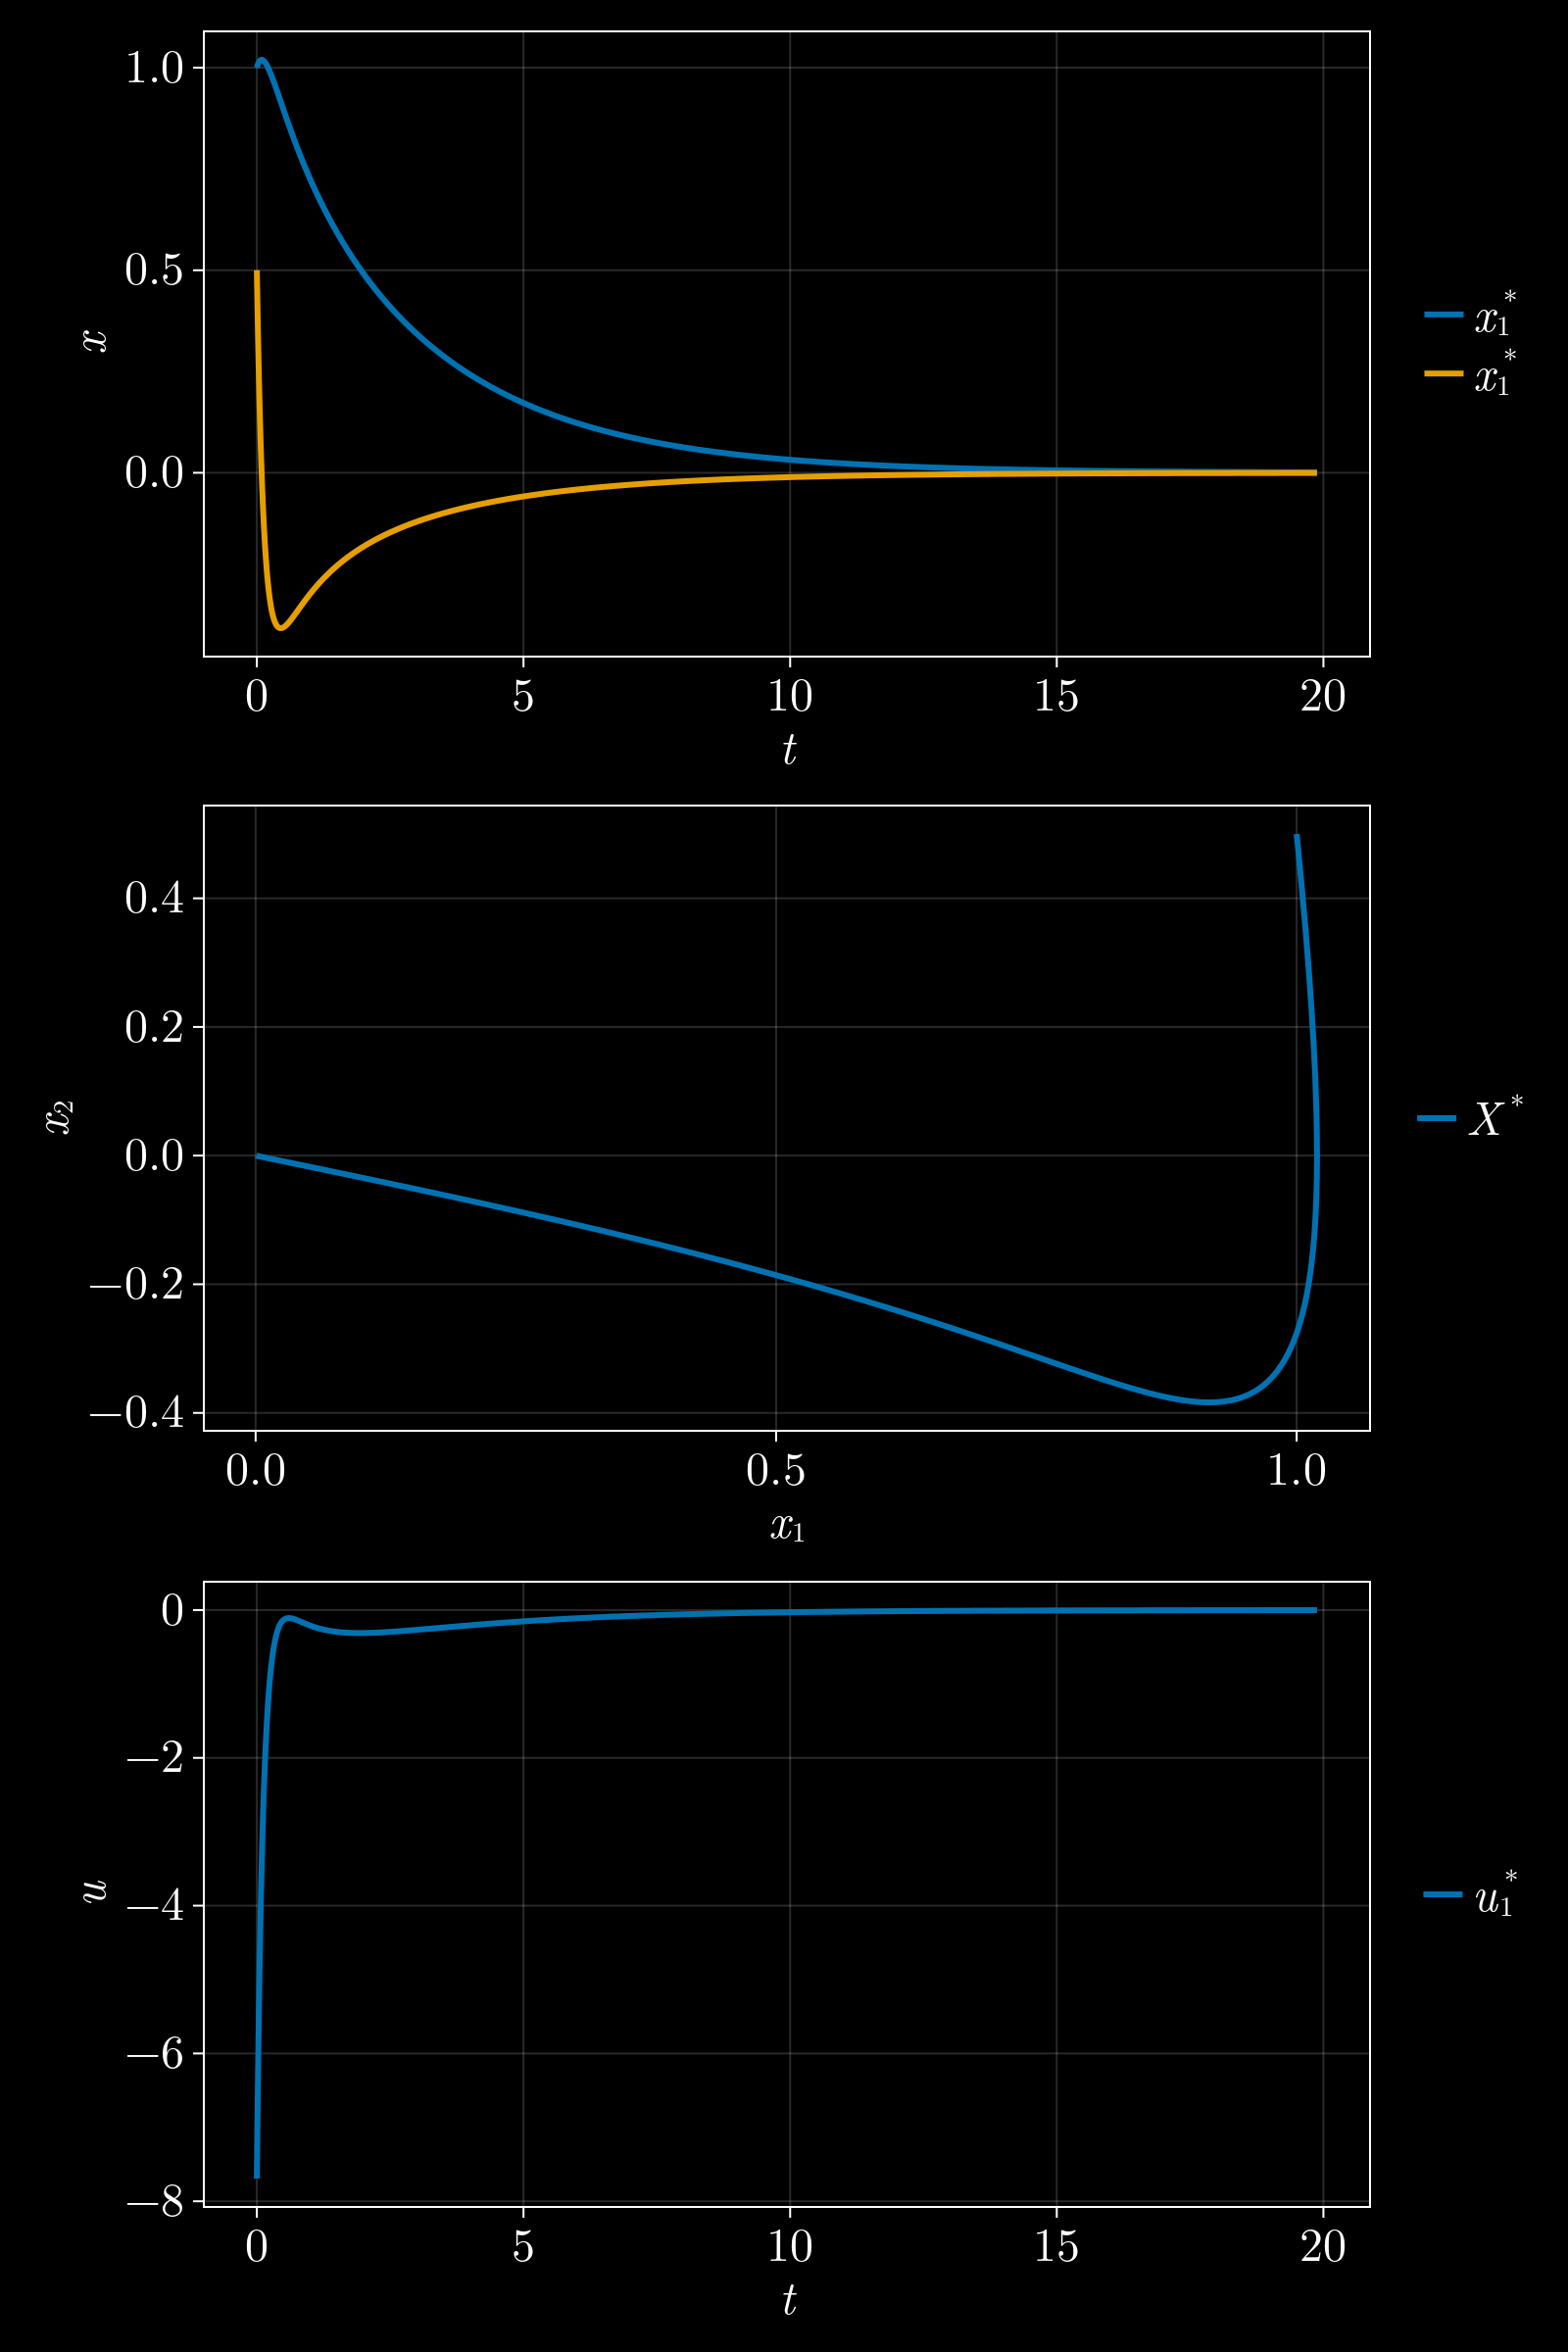

In [24]:
# Plot
f = Figure(fontsize = 24, size = (800,1200))
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x")
lines!(ax, t_MPC, x_MPC[1, :], label=L"x_1^*", linewidth=3)
lines!(ax, t_MPC, x_MPC[2, :], label=L"x_1^*", linewidth=3)
f[1, 2] = Legend(f, ax, framevisible = false)

ax = Axis(f[2, 1], xlabel = L"x_1", ylabel = L"x_2")
lines!(ax, x_MPC[1, :], x_MPC[2, :], label=L"X^*", linewidth=3)
f[2, 2] = Legend(f, ax, framevisible = false)

ax = Axis(f[3, 1], xlabel = L"t", ylabel = L"u")
lines!(ax, t_MPC, u_MPC, label=L"u_1^*", linewidth=3)
f[3, 2] = Legend(f, ax, framevisible = false)
f